# NLP Text Classification
By: Andrew Hendricks, Reyn Chagami, and David Hartsman

# Overview

Social media provides organizations with more data than ever about how the public is engaging with their products and brands. Using text classification to process all of that data into useable insights gives organizations the opportunity to incorporate public perceptions into their operations in new and unprecedented ways.

In this project, we take on the role of a consulting firm creating an NLP text classification prototype that we are pitching to the heads of the analytics and operations teams for SXSW 2024. We use Twitter data from the 2013 SXSW conference to create a model that classifies positive, negative, and neutral Tweet sentiment. We conclude by sharing ideas for how the SXSW operations team could use the results of our model to enhance future conferences and ideas for next steps.

# Project Summary

### Business Problem

The stakeholders for this project are the SXSW 2024 operations team and analytics team. The business problem is developing a model that classifies Tweets based on positive, negative, or neutral sentiment. Based on the business context, we developed three separate models: a binary model to classify positive Tweets, a binary model to classify negative Tweets, and a multi-class model to classify positive, negative, and neutral Tweets. We trained these models on 8,936 labeled Tweets from the 2013 SXSW conference. The Tweets reference products from Apple and Google, and 60% of them are labeled neutral, 33% are positive, and 6% are negative.

![Brand Sentiment Levels](./Data/brand_sentiment_ratios.jpg)

### Data Preparation

In [2]:
# Imports 

import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier

import xgboost
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 20)

In order to transform our text data into numeric data suitable for modeling, we needed to preprocess the data fairly extensively. Before we began processing the tweet text, we created a feature column for the brand of the product referenced in the tweet. For the missing brand values, we searched the contents of tweets for certain keywords, and then imputed those missing values. We then began to prepare the tweets themselves. We utilized the NLTK library in many different ways. We used NLTK's "RegexpTokenizer" to create individual token words. We used "stopwords" to help create a list of stop words which we removed from our corpus.  Then parts of speech were added  via the "pos_tag" function and we improved those parts of speech by utilizing a function that applied NLTK's "wordnet" parts of speech. We also ensured that all tokens were lower cased using a list comprehension. Then, we used the WordNetLemmatizer, also from NLTK, to improve upon the parts of speech that were intially assigned to our tokens. The final step for our text preparation was joining these tokens into one string using the ".join()" method. These transformations were executed by the following functions:

In [3]:
# Function for improving parts of speech information

### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [9]:
# Function for handling the transformation of data

def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc

In [13]:
# Import the original data
original_df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)

##### Example of tweet before transformation:

In [14]:
# An example tweet
original_df.loc[0, "tweet_text"]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

##### Example of tweet after transformation:

In [15]:
# Re-joined string of lemmatized words
preprocess(original_df.loc[0,"tweet_text"])

'wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw'

### Strategy for Modeling

Before conducting the final elements of data preparation, we determined that there were three different approaches to classifying this data that we wanted to pursue. The purpose of our first model is to detect positive Tweets. The stakeholders' operations team could use this model to identify and share positive public response with participating companies, which those companies could then repost on their social media accounts. SXSW could also use these Tweets to publicize positive reactions to the event for the purpose of attracting new companies to present at SXSW in the future. 

Our second model detects negative Tweets to support the operations team in detecting operational issues that people are complaining about publicly on social media. This can help monitor for sentiment issues that we may not be aware of, but that our attendees and customers are displeased by. 

Our third model is a multi-class classifier that distinguishes between positive, negative, and neutral Tweets. The operations team could use this model to gain insights about public reaction to the products and presentations that companies share throughout the conference. The team could share these insights both with companies to help them quantify the impact of presenting at SXSW on social media. SXSW could use the model internally to determine which companies to prioritize inviting to future conferences and which companies not to invite back. 

For positive and negative Tweet classification, we used one-versus-rest binary classification in order to develop our models. For the purposes we outlined above, positive OVR models should maximize precision because we wanted to make sure that if the operations team looking for positive social media posts to amplify, that the Tweets actually are positive at the highest possible rate. Our approach to negative OVR models was to emphasize recall, as we want to maximize our awareness of any public discontent, even if that includes more erroneously diagnosed negative posts. For multi-class models, our key metric is the overall accuracy score. We want to make sure that the model's classifications are as correct as possible to best appraise overall sentiment.

# Modeling

The different approaches and use cases we outlined above each require different preparation of the target variables. As such we prepared three different versions of target variables. We also wanted to assess model performance using both Count Vectorization and TF-IDF vectorization to transform our tweets into numeric data. The final preprocessing technique we employed was using SMOTE to synthetically up-sample our minority class. Before we can do any of that, though, we needed to separate our data using a train-test split.

In [35]:
# Data we used for our modeling process

# This data represents our multi-class target variable

df = pd.read_csv("./Data/NLP_all_targets.csv", index_col=0)
df.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0,1.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0,2.0


In [36]:
# Creation of both One VS Rest target variables

# For negative one vs rest
df["OVR-Negative"] = df["target"].apply(lambda x: 1 if x == 1 else 0)

# For positive one vs rest
df["OVR-Positive"] = df["target"].apply(lambda x: 1 if x == 2 else 0)

In [37]:
# Notice the addition of 2 additional columns

df.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target,OVR-Negative,OVR-Positive
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0,1.0,1,0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0,2.0,0,1


In [38]:
# Creating two sets of X and y variables for both OVR targets, both X's are the same, but shown separately

# Target, features for positive ovr
X_positive = df.drop(columns=["target", "OVR-Negative", "OVR-Positive"]).copy()
y_positive = df["OVR-Positive"].copy()

# Target, features for negative ovr
X_negative = df.drop(columns=["target", "OVR-Positive", "OVR-Negative"]).copy()
y_negative = df["OVR-Negative"].copy()

In [39]:
# Ratios of positive to not-positive labels

y_positive.value_counts()

0    5958
1    2978
Name: OVR-Positive, dtype: int64

In [40]:
# Ratios of negative to not-negative labels, as you can see this is quite unbalanced

y_negative.value_counts()

0    8366
1     570
Name: OVR-Negative, dtype: int64

##### Train-Test Split for OVR Models

In [41]:
# Train test split on the data, stratifying because of the relatively imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X_positive, y_positive, random_state=42, stratify=y_positive)

# Will show X_positive, y_positive, for demonstration, same process used for X_negative, y_negative

##### Vectorizers

In [42]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Count Vectorizer
count_vectorizer = CountVectorizer()

##### Function to concatenate vectorized text back with the rest of the X variable components

In [43]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

In [44]:
# Using both vectorizers on our data

# TF-IDF Vectorized Version of the X_train DataFrame
X_train_tfidf = combine_train_vectorization(X_train, "tokens", tfidf)
X_test_tfidf = combine_test_vectorization(X_test, "tokens", tfidf)

# Count Vectorized Version of X_train DataFrame
X_train_count = combine_train_vectorization(X_train, "tokens", count_vectorizer)
X_test_count = combine_test_vectorization(X_test, "tokens", count_vectorizer)

##### SMOTE

In [45]:
# TF-IDF vector Smote
smote1 = SMOTE(random_state=42)
X_train_smote_tfidf, y_smote_tfidf = smote1.fit_resample(X_train_tfidf, y_train)

# Count Vector Smote
smote2 = SMOTE(random_state=42)
X_train_smote_count, y_smote_count = smote2.fit_resample(X_train_count, y_train)

##### Class for Data Tracking and Functionality
We also created a class that allowed us to store the performance metrics of every model iteration. It also features some built in functions for plotting.

In [60]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        plt.style.use("seaborn")
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        plt.style.use("seaborn")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=26)
        # Create the plot
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    def confusion_matrix(self):
        plt.style.use('seaborn-white')
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title(f"Confusion Matrix for {self.name} Test Data");
    
    
    def __repr__(self):
      return f"Model name: {self.name}"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

## One-Versus-Rest: Postive and Negative

Now that we have treated out data, we could begin the process of iterating through different models. We initially established a dummy model baseline, using the strategy of always predicting the most frequent class. After that, we created models using Logistic Regression, Multinomial Naive Bayes, Random Forest classifiers, AdaBoost, and XGBoost. For each given model, we used each of our differently treated pairs of data to train the models. 

In [61]:
# Dummy model instantiation
dummy = DummyClassifier(strategy="most_frequent")

# Transformation doesn't matter because it is the dummy model, it will pick the most frequent target regardless
dummy.fit(X_train_tfidf, y_train)

# Class object instantiation
dummy_0 = Model("Dummy", dummy, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


##### Demonstration of the class functionality

In [62]:
# Dataframe for tracking statistical performance
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.0,0.0,0.0,12.014551,0.666965,0.0,0.0,0.0,12.003795,0.5


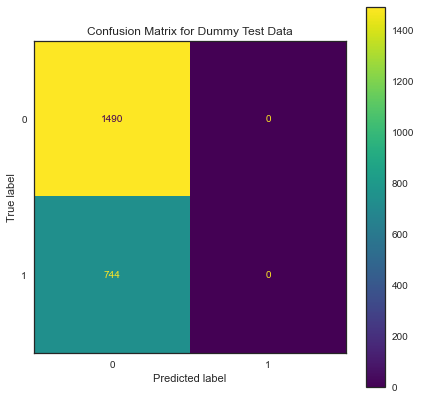

In [63]:
dummy_0.confusion_matrix()

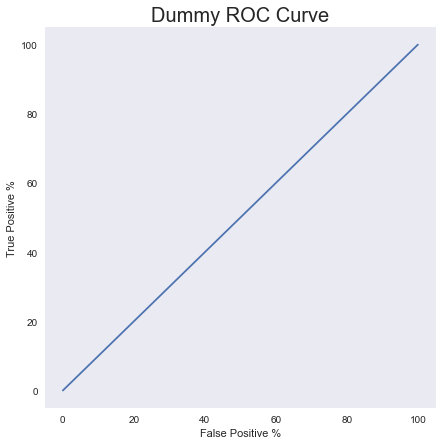

In [64]:
dummy_0.roc_curve()

##### More complex models
We then iterated through all of the types of models we described above. The target metric for Positive OVR was precision, and the target for Negative OVR was recall. This is an example of how we trained each model, but for the purposes of brevity, I will only show the implementation with Logistic Regression. You will notice that every type of transformation is utilized in training these models.

##### Training

In [65]:
# Classifier Objects

# TFIDF
lr_tfidf = LogisticRegression(random_state=42, n_jobs=-4)

# COUNT
lr_count = LogisticRegression(random_state=42, n_jobs=-4)

# SMOTE TFIDF
lr_tfidf_smote = LogisticRegression(random_state=42, n_jobs=-4)

# SMOTE COUNT
lr_count_smote = LogisticRegression(random_state=42, n_jobs=-4)


# Fitting each of the models 

# TFIDF natural
lr_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
lr_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
lr_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
lr_count_smote.fit(X_train_smote_count, y_smote_count)

LogisticRegression(n_jobs=-4, random_state=42)

##### Model Object Instantiation

In [66]:
# THIS CELL TAKES ABOUT 2 MINUTES TO RUN

# Class Model object instantiation

#TF-IDF model object
lr_TF = Model("Logistic TF-IDF", lr_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
lr_C = Model("Logistic Count-Vect", lr_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
lr_TF_S = Model("Logistic TF-IDF Smote", lr_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
lr_C_S = Model("Logistic Count Smote", lr_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   29.8s finished


##### Class Comparisons

In [68]:
# Checking statistical performance in the DataFrame

Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590


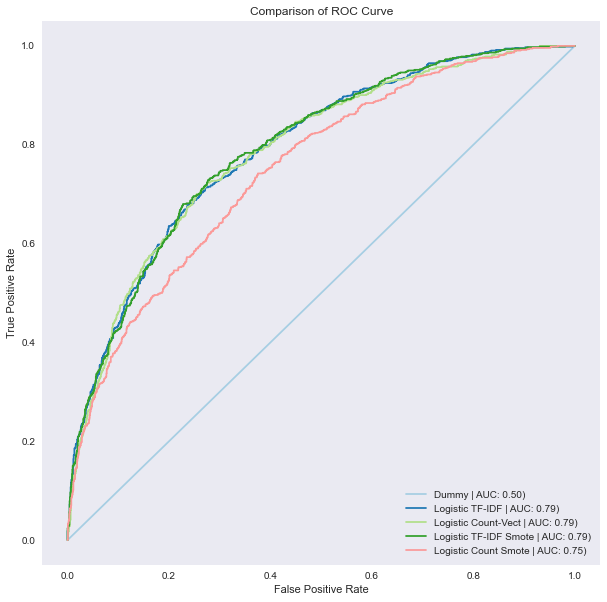

In [69]:
# Plotting all of the ROC curves for the first group of models created

lr_C_S.compare_roc_curve()

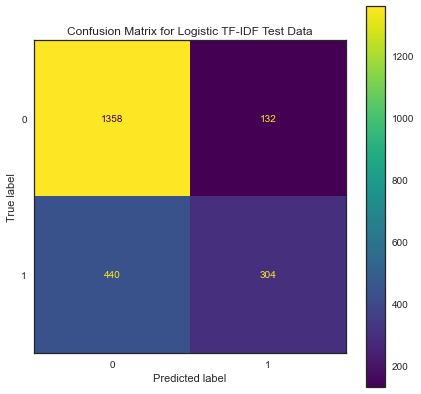

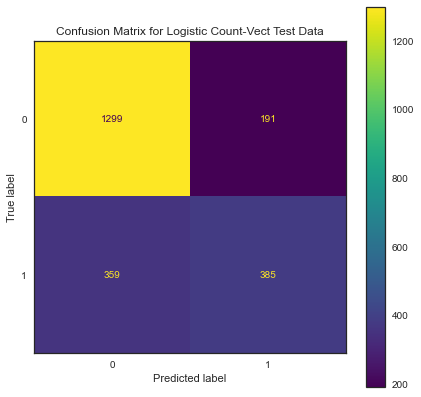

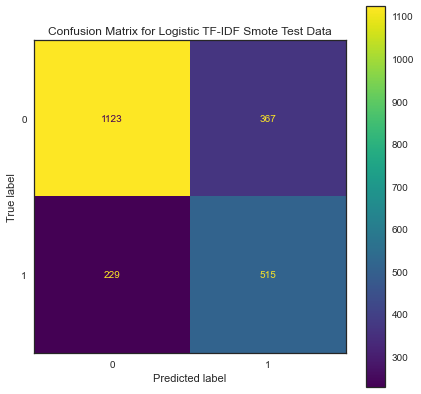

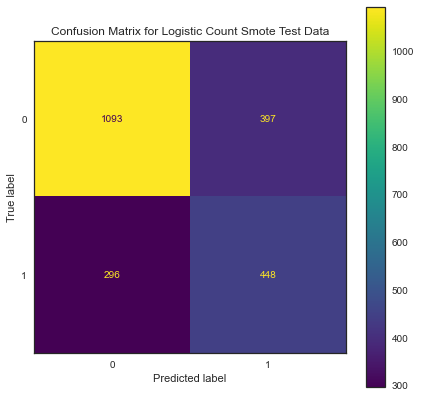

In [71]:
# Confusion Matrices for the Logistic Regression models

for i in range(1, len(Model.model_list)):
    Model.model_list[i].confusion_matrix()

This same process was repeated until we had trained all of our chosen models. Here are the results from each OVR range of models:

### Positve OVR Results

In [75]:
# Because precision was our target metric, the data will be presented with best precision top to bottom

positive_ovr = pd.read_csv("./Data/positive_OVR.csv", index_col=0)
positive_ovr.sort_values(by="test_prec", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
18,XGBoost Count-Vect,0.742319,0.693660,0.406906,0.512137,0.517572,0.742614,0.706601,0.388441,0.501301,0.521305,0.778349
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
21,LR Liblinear TFIDF,0.736199,0.686535,0.384069,0.492072,0.518146,0.743509,0.695652,0.408602,0.514818,0.511983,0.790627
17,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444
9,Random Forest TF-IDF,0.742317,0.715644,0.377360,0.493411,0.546722,0.739033,0.688525,0.395161,0.502135,0.558885,0.773991
10,Random Forest Count-Vect,0.741421,0.684685,0.415399,0.516956,0.567920,0.736795,0.674888,0.404570,0.505882,0.587593,0.778275
22,LR Liblinear COUNT,0.740227,0.643362,0.496871,0.559925,0.531629,0.754252,0.668977,0.518817,0.584406,0.525488,0.786819
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
14,AdaBoost Count-Vect,0.725157,0.667237,0.350505,0.458705,0.684455,0.717099,0.642132,0.340054,0.444640,0.685231,0.741481


### Negative OVR Results

In [76]:
# Because recall was our target metric, the data will be presented with best recall top to bottom

negative_ovr = pd.read_csv("./Data/negative_OVR.csv", index_col=0)
negative_ovr.sort_values(by="test_recall", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
21,Grid Searched MNB TF-IDF/SMOTE,0.930348,0.884845,0.989480,0.934239,0.211753,0.879588,0.286195,0.598592,0.387244,0.321193,0.836665
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
16,AdaBoost Count Smote,0.841093,0.806711,0.895606,0.847921,0.662120,0.780215,0.141684,0.485915,0.219396,0.663307,0.733293
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817
20,XGBoost Count Smote,0.914013,0.887613,0.947567,0.915397,0.247592,0.861235,0.197842,0.387324,0.261905,0.313035,0.766880
12,Random Forest Count Smote,0.928198,0.898717,0.964939,0.929755,0.248263,0.871083,0.210317,0.373239,0.269036,0.449279,0.797592
15,AdaBoost TF-IDF Smote,0.879506,0.895495,0.858947,0.875978,0.663279,0.866607,0.202290,0.373239,0.262376,0.672024,0.772194
2,Logistic Count-Vect,0.938526,0.585377,0.137811,0.220956,0.184884,0.943151,0.659574,0.218310,0.328042,0.178534,0.846313


## One-Versus-Rest Evaluation

Our strongest model for Positive OVR was the Mutlinomial Naive Bayes classifier that used TF-IDF vectorization. The model precision for train data was 68% and the precision for test data was 73%. Of the Tweets that it classified as positive, 163 actually were positive and 59 were false positives.

Our strongest model for Negative OVR was again, a Mutlinomial Naive Bayes classifier that used TF-IDF vectorization, however it also used the SMOTE up-sampled data. The model recall for train data was 98% and the recall for test data was 63%. While that is a tremendous drop off, it still represents the best performance of all models that we were able to create. Of the Tweets labeled as negative, it correctly classified 90 as negative and incorrectly classified 52.

Given that our intention with these models did not require overall accuracy, our next steps would be attempting to modify the thresholds for classification depending on how well these models perform in the wild. By moving the threshold in either direction from .5 could help to more efficiently achieve our business related goals.

## Multi-class Modeling RRRRREEEEEEYYYYYYNNNNNNNN

## Multi-class Modeling Evaluation

# Conclusion

While our models substantially outperform dummy classifiers, they do not achieve the level of precision, recall, and accuracy that we would want to offer a client for real world use. We believe that the main cause source of the issue is the limited amount of data used to train the model. If we were to continue the project, our next steps would be to use a larger data set to train the model, to find data with date and time markers to allow us to visualize how the emotion classifications change over time, to explore relationships between the social media data and related data such as sales or attendance, and to create critical thresholds that identify the need for an immediate response. We would also want to pursue methods like Latent Dirilichlet Allocation and Sentiment Analysis to get more sophisticated insights than simple classification.

# THIS IS HERE AS A REFERENCE COMING FROM THE ASSIGNMENT PAGE - DELETE THIS CELL AFTER YOU HAVE COMPLETED ENTERING YOUR WORK
Summary elements:

- Business and data understanding: what kind of data are you using, and what makes it well-suited for the business problem?
You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics
- Data preparation: why did you choose the data preparation steps that you did, and what was the result?
This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
Be sure to list the packages/libraries used to prepare the data, and why
- Modeling: what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice
- Evaluation: how well did your final model perform?
Include one or more relevant metrics
Be sure to briefly describe your validation approach